# Import Required Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from tqdm import tqdm
import itertools
from collections import defaultdict
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, wordpunct_tokenize, TreebankWordTokenizer, TweetTokenizer, MWETokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import pad_sequence, bigrams, ngrams, everygrams
from nltk.lm.preprocessing import pad_both_ends, flatten

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

sns.set_theme(style="white")
%matplotlib inline

/home/ahura/anaconda3/envs/MyEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


---

# Read Train and Test Datasets

In [3]:
train = pd.read_csv('./train/train.csv')
test = pd.read_csv('./train/test.csv')


label_column = 'Class'
text_column = 'Text'

In [4]:
train.head()

,Text,Class
0,I do.,0
1,What if anything was decided about whether I s...,0
2,H: If Roubini is right and he's been mostly ri...,0
3,HRC: Below is an oped on the National Security...,0
4,DQoNCg0KDQoNCg0KDQpHb29kIERheSwNCk1heSBpdCBub3...,1


---

# Tokenization

In [5]:
def nltk_stopwords():
    nltk.download('stopwords')
    stop_words = set(stopwords.words("english"))
    return stop_words

stopwords = nltk_stopwords()
    
def aggregate_tokens(tokens_series: pd.Series):
    return list(itertools.chain.from_iterable(tokens_series.tolist()))

def data_tokenize(series: pd.Series, tokenizer):
    tokens_series = series.apply(lambda txt: tokenizer(str(txt)))
    return aggregate_tokens(tokens_series)


def ham_spam_data_split(data):
    spam_data = train.loc[train[label_column] == 1, :]
    ham_data = train.loc[train[label_column] == 0, :]    

    return ham_data, spam_data

ham_data, spam_data = ham_spam_data_split(train)

tokenizer = wordpunct_tokenize
spam_data_tokens = data_tokenize(spam_data[text_column], tokenizer=tokenizer)
ham_data_tokens = data_tokenize(ham_data[text_column], tokenizer=tokenizer)

[nltk_data] Downloading package stopwords to /home/ahura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---

# Get Insight about Stopwords and Punctuations

### Insight about Dataset Stopwords

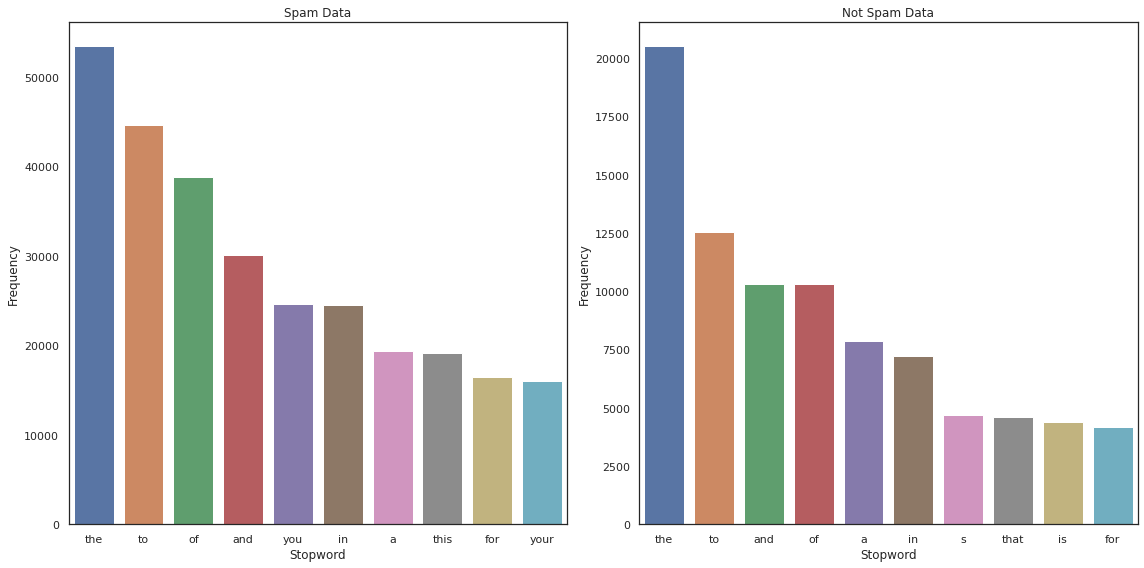

In [6]:

def get_top_k_results(dictionary, k):
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:k]

def build_corpus_stopwords_dictionary(corpus):
    stopwords_dict = defaultdict(int)
    
    for word in corpus:
        if word in stopwords:
            stopwords_dict[word] += 1

    return stopwords_dict

spam_sw_topk = get_top_k_results(build_corpus_stopwords_dictionary(spam_data_tokens), k=10)
ham_sw_topk = get_top_k_results(build_corpus_stopwords_dictionary(ham_data_tokens), k=10)

plt.figure(figsize=(16,8))
X = 'Stopword'
Y = 'Frequency'
plt.subplot(1, 2, 1)
sns.barplot(x=X, y=Y, data=pd.DataFrame(spam_sw_topk, columns=[X, Y]))
plt.title('Spam Data')

plt.subplot(1, 2, 2)
sns.barplot(x=X, y=Y, data=pd.DataFrame(ham_sw_topk, columns=[X, Y]))
plt.title('Not Spam Data')

plt.tight_layout()
plt.show()

### Insights about Dataset Punctuations

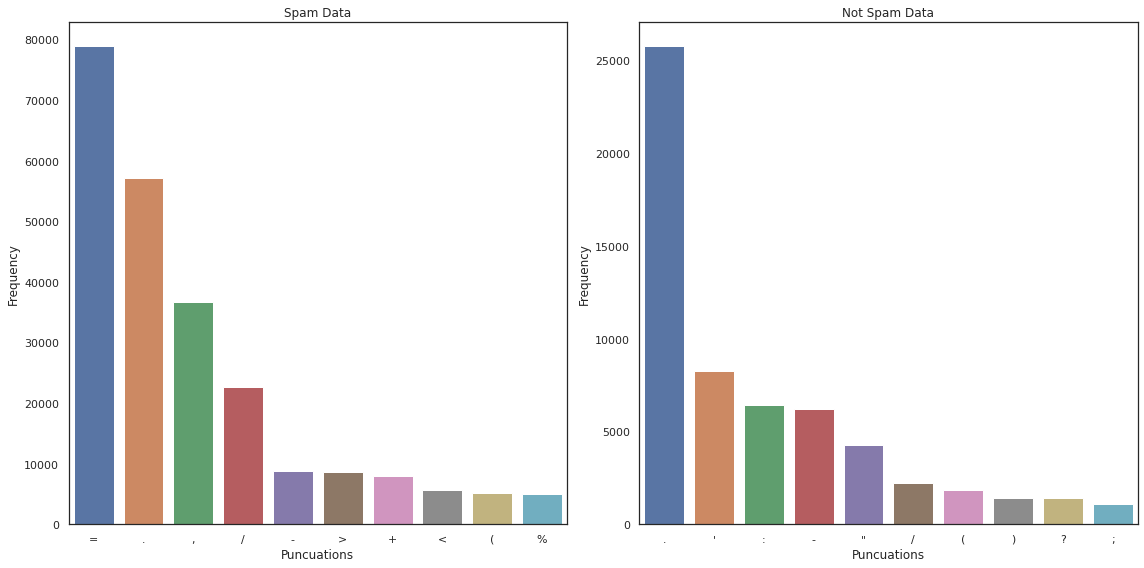

In [7]:
def build_corpus_punctuations_dictionary(corpus):
    puncs_dict = defaultdict(int)
    for word in corpus:
        if word in string.punctuation:
            puncs_dict[word] += 1

    return puncs_dict

spam_puncs_topk = get_top_k_results(build_corpus_punctuations_dictionary(spam_data_tokens), k=10)
ham_puncs_topk = get_top_k_results(build_corpus_punctuations_dictionary(ham_data_tokens), k=10)

plt.figure(figsize=(16,8))
X = 'Puncuations'
Y = 'Frequency'
plt.subplot(1, 2, 1)
sns.barplot(x=X, y=Y, data=pd.DataFrame(spam_puncs_topk, columns=[X, Y]))
plt.title('Spam Data')

plt.subplot(1, 2, 2)
sns.barplot(x=X, y=Y, data=pd.DataFrame(ham_puncs_topk, columns=[X, Y]))
plt.title('Not Spam Data')

plt.tight_layout()
plt.show()

---

# Dataset Cleaning (Part 1)

## Remove URLs And HTMLs

In [8]:
def remove_URL(text):
    text = str(text)
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_HTML(text):
    text = str(text)
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

## Remove Emojis

In [9]:
def remove_emoji(text):
    text = str(text)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

## Remove Punctuations

In [10]:
def remove_punctuations(text):
    text = str(text)
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

## Remove Stopwords

In [11]:
def remove_stopwords(text, stopwords):
    text = str(text)    
    
    sws = stopwords.copy()
    sws = sws.union({'now', 'will', 'new'})
    text = [word.lower() for word in text.split() if word.lower() not in sws]

    return " ".join(text)

## Remove Numbers

In [12]:
def remove_number(text):
    text = str(text)
    result = re.sub(r'\d+','', text)
    return result

## Clean up Pipline (Part 1)

In [13]:

def clean_up_pipeline(data):
    cleaning_functions = [
        str,
        str.strip,
        str.lower,
        remove_number,
        remove_URL,
        remove_HTML,
        remove_emoji,
        remove_punctuations,
    ]
    
    for function in cleaning_functions:
        data.loc[:, text_column] = data[text_column].map(function)
    
    data.loc[:, text_column] = data[text_column].map(lambda text: remove_stopwords(text, stopwords))
    
    return data
    
train = clean_up_pipeline(train)
test = clean_up_pipeline(test)

---

# Dataset Cleaning (Part 2)

## Word Tokenization (nltk `word_tokenize` function)

In [14]:
print('Train Texts Tokenization ...')
train_texts_tokens = [word_tokenize(text) for text in tqdm(train[text_column].tolist())]

print('Test Texts Tokenization ...')
test_texts_tokens = [word_tokenize(text) for text in tqdm(test[text_column].tolist())]

Train Texts Tokenization ...


100%|██████████| 9543/9543 [02:38<00:00, 60.35it/s] 


Test Texts Tokenization ...


100%|██████████| 2386/2386 [00:29<00:00, 82.11it/s] 


## Lemmatization / Stemming (Lemmatization used in this case)

In [15]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

lemmatized_train_texts_tokens = [list(map(lemmatizer.lemmatize, tokens)) for tokens in train_texts_tokens]
lemmatized_test_texts_tokens = [list(map(lemmatizer.lemmatize, tokens)) for tokens in test_texts_tokens]

lemmatized_train_text = [" ".join(tokens) for tokens in lemmatized_train_texts_tokens]
lemmatized_test_text = [" ".join(tokens) for tokens in lemmatized_test_texts_tokens]

train[text_column] = lemmatized_train_text
test[text_column] = lemmatized_test_text

---

# Dataset Visualization

## WordCloud

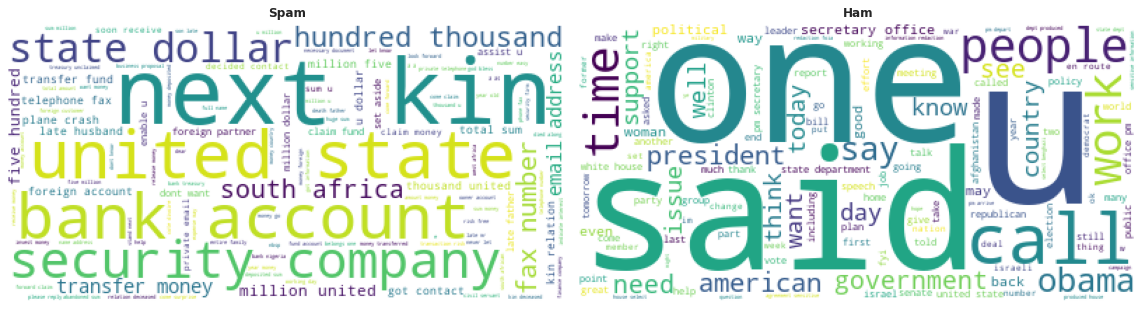

In [16]:
ham_data, spam_data = ham_spam_data_split(train)

tokenizer = TreebankWordTokenizer().tokenize
spam_data_tokens = data_tokenize(spam_data[text_column], tokenizer)
ham_data_tokens = data_tokenize(ham_data[text_column], tokenizer)


wc_bg_color = "white"
spam_word_cloud = WordCloud(background_color=wc_bg_color,).generate(
    " ".join(spam_data_tokens)
)
                            
ham_word_cloud = WordCloud(background_color=wc_bg_color,).generate(
    " ".join(ham_data_tokens)
)

plt.figure(figsize=(16, 8 ))

plt.subplot(1, 2, 1)
plt.imshow(spam_word_cloud)
plt.title('Spam', fontweight="bold")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_word_cloud)
plt.title('Ham', fontweight="bold")
plt.axis('off')

plt.tight_layout()
plt.show()

## n-Gram Barcharts

In [17]:
def calculate_text_data_ngram(data, n):
    texts_ngrams = data['Text'].apply(lambda txt: list(ngrams(txt.split(" "), n=n))).tolist()
    aggregated_ngrams = list(itertools.chain.from_iterable(texts_ngrams))
    
    aggregated_ngrams = list(map(lambda str_tuple: " ".join(list(str_tuple)), aggregated_ngrams))
    return aggregated_ngrams

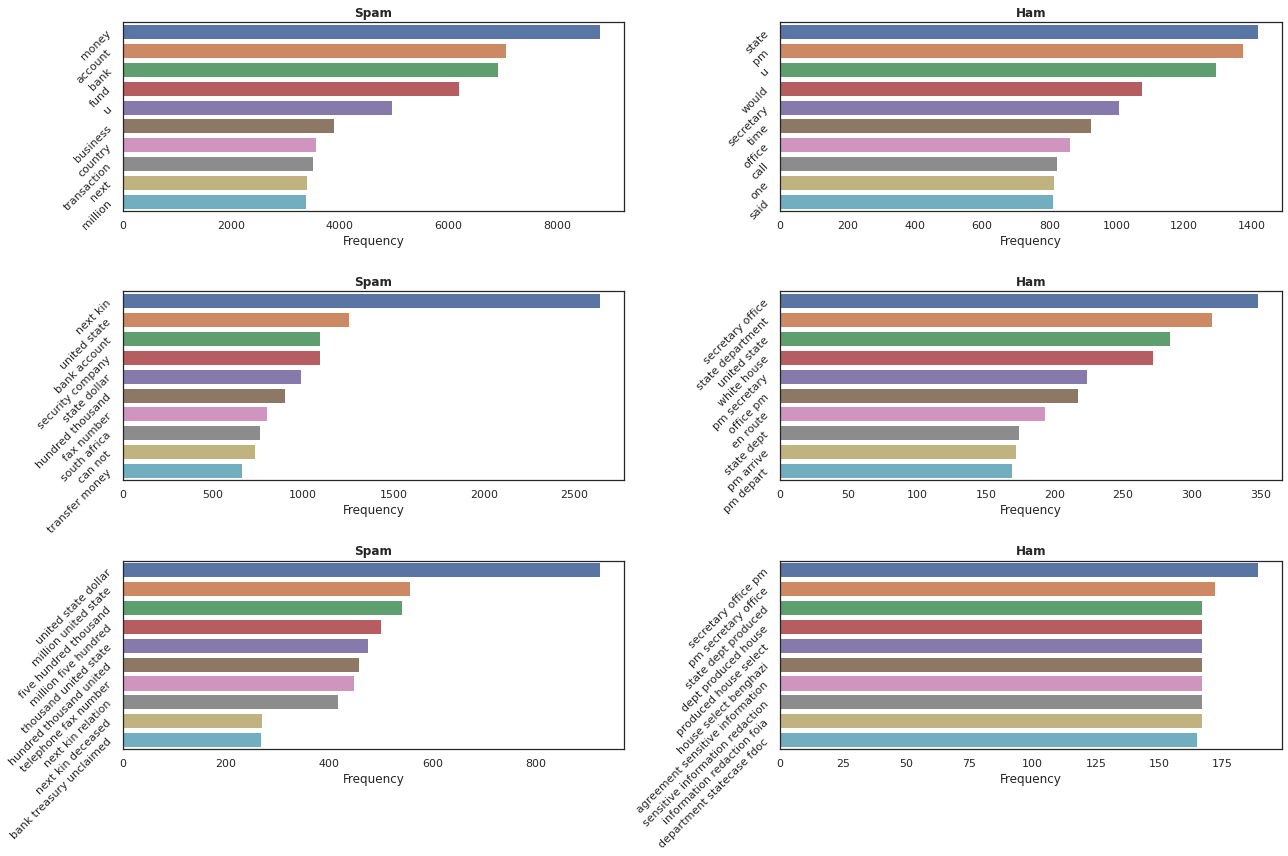

In [18]:
def build_word_to_count_dictionary(word_list):
    stopwords_dict = defaultdict(int)

    for word in word_list:
        stopwords_dict[word] += 1

    return stopwords_dict

ham_data, spam_data = ham_spam_data_split(train)

k = 10
max_n = 3

plt.figure(figsize=(max_n * 6, 12))
for i in range(max_n):
    
    i_gram = i + 1
    spam_n_gram_top_k = get_top_k_results(build_word_to_count_dictionary(calculate_text_data_ngram(spam_data, n=i_gram)), k=k)
    ham_n_gram_top_k = get_top_k_results(build_word_to_count_dictionary(calculate_text_data_ngram(ham_data, n=i_gram)), k=k)

    X = 'n-Gram'
    Y = 'Frequency'
    plt.subplot(max_n, 2, i * 2 + 1)
    sns.barplot(x=Y, y=X, data=pd.DataFrame(spam_n_gram_top_k, columns=[X, Y]), orient='h')
    plt.yticks(rotation=45)
    plt.ylabel('')
    plt.title('Spam', fontweight="bold")

    plt.subplot(max_n, 2, i * 2 + 2)
    sns.barplot(x=Y, y=X, data=pd.DataFrame(ham_n_gram_top_k, columns=[X, Y]), orient='h')
    plt.yticks(rotation=45)
    plt.ylabel('')
    plt.title('Ham', fontweight="bold")
    
plt.tight_layout()
plt.show()

---

# Feature Extraction

## TF-IDF Vectorizer

In [19]:
train_text = [text.split(" ") for text in train[text_column].tolist()]
test_text = [text.split(" ") for text in test[text_column].tolist()]

vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(train[text_column])
y = train[label_column]


x_test = vectorizer.transform(test[text_column])

---

# Split Train Dataset To Train and Validation Parts

In [20]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2, random_state=42)

---

# Model Training

In [22]:
from time import time

def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_validation)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_validation, pred)
    print("accuracy:   %0.3f" % score)

    print("classification report:")
    print(classification_report(y_validation, pred, target_names=['Ham', 'Spam']))

    print("confusion matrix:")
    print(confusion_matrix(y_validation, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=500, penalty=penalty)))

# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=500, penalty="elasticnet"))
)

# Train NearestCentroid without threshold
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

print("=" * 80)


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.173s
test time:  0.001s
accuracy:   0.972
classification report:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.98      1094
        Spam       1.00      0.93      0.97       815

    accuracy                           0.97      1909
   macro avg       0.98      0.97      0.97      1909
weighted avg       0.97      0.97      0.97      1909

confusion matrix:
[[1093    1]
 [  53  762]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=Non

/home/ahura/anaconda3/envs/MyEnv/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:557: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 0.022s
test time:  0.001s
accuracy:   0.977
classification report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98      1094
        Spam       0.99      0.95      0.97       815

    accuracy                           0.98      1909
   macro avg       0.98      0.97      0.98      1909
weighted avg       0.98      0.98      0.98      1909

confusion matrix:
[[1090    4]
 [  40  775]]

kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
train time: 0.002s
test time:  0.498s
accuracy:   0.661
classification report:
              precision    recall  f1-score   support

         Ham       0.63      1.00      0.77      1094
        Spam       1.00      0.21      0.34       815

    accuracy         

---

# Predict On Test Data (Save Prediction to `submission.csv`)

In [ ]:
clf = Perceptron(max_iter=1000)
clf.fit(x_train, y_train)
y_validation_predicted = clf.predict(x_validation)

score = accuracy_score(y_validation, y_validation_predicted)

y_test_predicted = clf._predict_proba_lr(x_test)

submition_predicts = pd.DataFrame((y_test_predicted[:, 1]), columns=[label_column])
pd.DataFrame.to_csv(submition_predicts,
                    'submission.csv',
                    index=False,
                    index_label=False)
